In [1]:
pip install openpyxl

     |████████████████████████████████| 242 kB 887 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import fasttext
from nltk.util import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Embedding,GRU,LSTM,Bidirectional,Dropout,Conv1D,MaxPooling1D,GlobalAveragePooling1D,Flatten,Input
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score,classification_report
from keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import gensim
from tqdm import tqdm
from gensim.models import word2vec
from sklearn import metrics


### Import excel file for MAIN DATA

In [3]:
df=pd.read_excel("../input/data-arabic-dialect/data_main.xlsx",index_col=0,
              dtype={'tokens': str, 'dialect': str})
## check the presence of null values
df.isna().sum()

tokens     0
dialect    0
dtype: int64

In [4]:
## reset index
df=df.reset_index()
df.drop('index',axis=1,inplace=True)

### count numbers of sentences that belong to each country

Index(['GULF', 'LEVANT', 'MAGHERB', 'NILE BASIN', 'IQ', 'YE'], dtype='object')


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='dialect'>

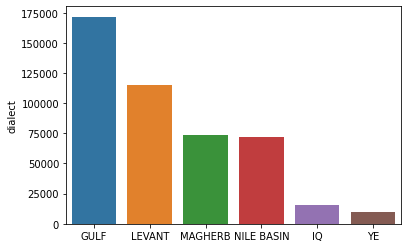

In [5]:
x=df['dialect'].value_counts()
print(x.index)
sns.barplot(x.index,x)

### compute the max number of words ( max_length of the sentence)

In [6]:
def splitolist(data):
    l=data.split(" ")
    return l

In [7]:
df['tokens1']=df['tokens'].apply(splitolist)

In [8]:
max_length=df.tokens1.str.len().max()
print("max length is"+" "+str(max_length))


max length is 86


In [9]:
df.loc[0,['tokens','dialect']][0]

'بالنهايه ينتفض يغير'

### create a corpus of the entire dataset in a txt file

In [10]:
with open(r'./corpus.txt', 'w', encoding='utf-8') as txtfile:
    for i in range(len(df)):
        line = df.loc[i,'tokens']
        txtfile.write(line)
        txtfile.write('\n')

### train skipgram model on the corpus to get word embeddings

In [11]:
EMBED_SIZE=100
model = fasttext.train_unsupervised('./corpus.txt',
                                    minCount = 5, 
                                    model='skipgram',
                                    minn = 2,
                                    maxn = 5,
                                    dim = 100,
                                    lr = 0.1,
                                    epoch = 10)

Read 5M words
Number of words:  85015
Number of labels: 0
Progress: 100.0% words/sec/thread:   79496 lr:  0.000000 avg.loss:  0.644193 ETA:   0h 0m 0s


In [12]:
#create a list of all unique words in the dataset
with open(r'./corpus.txt', 'r', encoding="utf-8") as txtfile:
    corpus_sentences = txtfile.readlines()
    corpus_words = []
    for sent in corpus_sentences:
        tokenized_sent = sent.split()
        for word_ in tokenized_sent:
            corpus_words.append(word_)
            
    corpus_unique_words = list(set(corpus_words))

### convert text to numbers using tokenizer

In [13]:
tokenizer = Tokenizer(num_words=len(corpus_unique_words)+1)
tokenizer.fit_on_texts(df['tokens'])
sequences = tokenizer.texts_to_sequences(df['tokens'])

In [14]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=max_length,padding='post')  ## padding all the sentences in the dataset to have the same length

Found 445328 unique tokens.


### create embedding matrix from the trained fasttext model

In [15]:
vocab_size = len(tokenizer.word_index)+1
embeddings_matrix = np.zeros(shape = (vocab_size , EMBED_SIZE))

for word, index in tqdm(tokenizer.word_index.items()):
    embeddings_matrix[index] = model.get_word_vector(word)

100%|██████████| 445328/445328 [00:05<00:00, 82179.52it/s]


In [16]:
data_y=pd.get_dummies(df['dialect'])

In [17]:
data_y[:10]

,GULF,IQ,LEVANT,MAGHERB,NILE BASIN,YE
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
5,0,1,0,0,0,0
6,0,1,0,0,0,0
7,0,1,0,0,0,0
8,0,1,0,0,0,0
9,0,1,0,0,0,0


In [18]:
#split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(data,data_y, test_size = 0.1, stratify =data_y,shuffle=True)

In [19]:
#create a bidirectional LSTM model
def create_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, EMBED_SIZE, 
                                weights=[embeddings_matrix], 
                                input_length=max_length , 
                                trainable=True)
    
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.5))
    model.add(Dense(5000, activation='relu'))
    model.add(Dense(len(np.unique(df['dialect'])), activation='softmax'))
    return model

model1 = create_model()
tf.keras.backend.clear_session()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss',mode = 'max',patience=3,verbose=1) #,mode = 'min',callbacks=[early_stop]
early_stopping = EarlyStopping(monitor='loss', patience=2)
tf.keras.backend.clear_session()
# early_stopping = EarlyStopping(monitor= 'val_acc', 
#                                mode = 'max',
#                                patience=30, 
#                                verbose=1)

# model_checkpoint = ModelCheckpoint('levant_dialect_CLASSIFIER',
#                                    monitor = 'val_acc', 
#                                    mode = 'max', 
#                                    save_best_only=True, 
#                                    verbose=1)


opt = Adam(learning_rate = 0.0001)

model1.compile(opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

2022-03-13 20:31:22.505555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 20:31:22.607630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 20:31:22.608310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 20:31:22.609329: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
np.unique(df['dialect']).tolist()

['GULF', 'IQ', 'LEVANT', 'MAGHERB', 'NILE BASIN', 'YE']

In [21]:
#train the model
history = model1.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test),
                    batch_size=32,
                    epochs=50,
                    callbacks = [early_stop])

2022-03-13 20:31:26.734757: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-13 20:31:29.822266: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12883/12883 [==============================] - 289s 22ms/step - loss: 0.9028 - accuracy: 0.6878 - val_loss: 0.7546 - val_accuracy: 0.7468
Epoch 2/50
12883/12883 [==============================] - 284s 22ms/step - loss: 0.6925 - accuracy: 0.7697 - val_loss: 0.7012 - val_accuracy: 0.7655
Epoch 3/50
12883/12883 [==============================] - 284s 22ms/step - loss: 0.6050 - accuracy: 0.8001 - val_loss: 0.6872 - val_accuracy: 0.7698
Epoch 4/50
12883/12883 [==============================] - 285s 22ms/step - loss: 0.5421 - accuracy: 0.8217 - val_loss: 0.6780 - val_accuracy: 0.7733
Epoch 00004: early stopping


In [32]:
model1.save("MAIN_MODEL.h5")

In [23]:
target_names=np.unique(df['dialect']).tolist()
target_names

['GULF', 'IQ', 'LEVANT', 'MAGHERB', 'NILE BASIN', 'YE']

In [24]:
y_test

,GULF,IQ,LEVANT,MAGHERB,NILE BASIN,YE
378228,1,0,0,0,0,0
413734,1,0,0,0,0,0
300371,0,0,0,0,1,0
404355,0,0,0,0,1,0
55847,1,0,0,0,0,0
...,...,...,...,...,...,...
139690,0,0,1,0,0,0
28344,0,0,0,1,0,0
258471,0,0,0,0,1,0
94459,0,0,1,0,0,0


In [25]:
np.argmax(np.array(y_test),axis=1)

array([0, 0, 4, ..., 4, 2, 0])

### classification report for test data

In [26]:
pred=model1.predict(x_test)
print(classification_report(np.argmax(np.array(y_test),axis=1),np.argmax(pred,axis=1), target_names=target_names))

              precision    recall  f1-score   support

        GULF       0.77      0.88      0.82     17168
          IQ       0.66      0.50      0.57      1549
      LEVANT       0.79      0.74      0.76     11549
     MAGHERB       0.78      0.68      0.73      7344
  NILE BASIN       0.78      0.80      0.79      7202
          YE       0.44      0.13      0.20       992

    accuracy                           0.77     45804
   macro avg       0.70      0.62      0.65     45804
weighted avg       0.77      0.77      0.77     45804



### classification report for train data

In [27]:
pred_train=model1.predict(x_train)
print(classification_report(np.argmax(np.array(y_train),axis=1),np.argmax(pred_train,axis=1), target_names=target_names))

              precision    recall  f1-score   support

        GULF       0.83      0.94      0.88    154516
          IQ       0.82      0.62      0.71     13941
      LEVANT       0.86      0.82      0.84    103937
     MAGHERB       0.88      0.78      0.83     66098
  NILE BASIN       0.85      0.88      0.87     64816
          YE       0.68      0.22      0.33      8928

    accuracy                           0.85    412236
   macro avg       0.82      0.71      0.74    412236
weighted avg       0.85      0.85      0.84    412236



In [28]:
a="توحشتك"
l=splitolist(a)
seq=tokenizer.texts_to_sequences(l)
b=[item for sublist in seq for item in sublist]
print(b)
pad_seq=pad_sequences([b], maxlen=max_length,padding='post')

[5590]


In [29]:
print(l,seq,pad_seq)

['توحشتك'] [[5590]] [[5590    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [30]:
out=model1.predict(pad_seq).argmax(axis=1)
out[0]

3

In [31]:
country_pred=target_names[out[0]]
country_pred

'MAGHERB'